In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.io
import cmocean 
import sys
sys.path.insert(1, '/Users/emmagurcan/Documents/France/ENS/M1/stageM1/analysis')
from functions_MSM74 import *
import matplotlib.ticker as ticker
import netCDF4 as nc
import cartopy.crs as ccrs
import gsw
from scipy.spatial import cKDTree
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm, PowerNorm


In [2]:
raw_ctd = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/raw_ctd.nc"
clean = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/clean_ctd.nc"
clean_lonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/clean_lonlatev.nc"
nclonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_lonlat.nc"
readcp = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74-VMADCP_allfiles/msm_074_1_vmadcp_75khz_01.nc"
rep = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_CTD.tab"
lon_lat_event = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/lon_lat_event.nc"

In [3]:
ds_adcp = nc.Dataset(readcp)
ds_ctd = nc.Dataset(clean)
lonlatev = nc.Dataset(clean_lonlat)
cruise = "MSM74"
set_maxdepth(cruise)

In [4]:
ds_adcp.variables.keys()

dict_keys(['DEPTH', 'DEPTH_QC', 'TIME', 'TIME_QC', 'LATITUDE', 'LATITUDE_QC', 'LONGITUDE', 'LONGITUDE_QC', 'UCUR', 'UCUR_QC', 'VCUR', 'VCUR_QC', 'PINGS_PER_ENSEMBLE', 'PINGS_PER_ENSEMBLE_QC', 'ECHO_AMPLITUDE', 'ECHO_AMPLITUDE_QC', 'PERCENT_GOOD', 'PERCENT_GOOD_QC'])

In [5]:
ds_ctd.variables.keys()

dict_keys(['Attenuation [1_m]', 'Depth water [m]', 'Event', 'Fluorescence [arbitrary units]', 'Latitude', 'Longitude', 'O2 [umol_kg]', 'Press [dbar]', 'SV [m_s]', 'Sal', 'Sigma in situ [kg_m**3]', 'Temp [C]', 'Time', 'Turbidity [NTU]'])

In [6]:
# import numpy as np
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.cm as cm

# def plot_coords(lons, lats, title='Scatter Plot of MSM74', extent=[-70, -25, 50, 70], ax=None, color='red', label=None):
#     valid_indices = ~np.isnan(lats) & ~np.isnan(lons)
#     lats_clean = lats[valid_indices]
#     lons_clean = lons[valid_indices]

#     # Create an axis with a PlateCarree projection if one is not provided
#     if ax is None:
#         fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

#     # Set map boundaries (focusing on the Labrador Sea)
#     ax.set_extent(extent, crs=ccrs.PlateCarree())

#     # Add coastlines, borders, and gridlines for reference
#     ax.coastlines(resolution='50m')
#     ax.add_feature(cfeature.BORDERS, linestyle=':')
#     gl = ax.gridlines(draw_labels=True)
    
#     # Plot the scatter points with the specified color and label
#     ax.scatter(lons_clean, lats_clean, s=10, color=color, alpha=0.7, 
#                transform=ccrs.PlateCarree(), label=label)
#     ax.set_title(title)
#     return ax

# # List of section numbers to plot
# section_nums = [1, 2, 3, 4, 5, 6, 7]

# # Generate distinct colors for each section using the viridis colormap
# colors = cm.viridis(np.linspace(0, 1, len(section_nums)))

# # Create the main figure and axis (with a Cartopy PlateCarree projection)
# fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# extent = [-70, -25, 50, 70]  # Map extent: [lon_min, lon_max, lat_min, lat_max]

# # Loop through each section, plotting the corresponding coordinates with a unique color and label
# for section_num, color in zip(section_nums, colors):
#     times, press, depth, T, S, lon, lat, inv_x, lat_adcp_section, lon_adcp_section, depth_adcp, u_adcp, v_adcp = load_data(section_num, lonlatev, ds_ctd, ds_adcp)

#     # The label now includes the section number for the legend
#     plot_coords(lon, lat, extent=extent, title="CTD MSM74", ax=ax, color=color, label=f"Section {section_num}")

# # Add the legend once after all sections have been plotted
# ax.legend(fontsize=8, loc='lower right')
# plt.show()


In [20]:
section_num = 7
times, press, depth, T, S, lon, lat, inv_x, lat_adcp_section, lon_adcp_section, depth_adcp, u_adcp, v_adcp = load_data(section_num, lonlatev, ds_ctd, ds_adcp)
# inv_x = 0

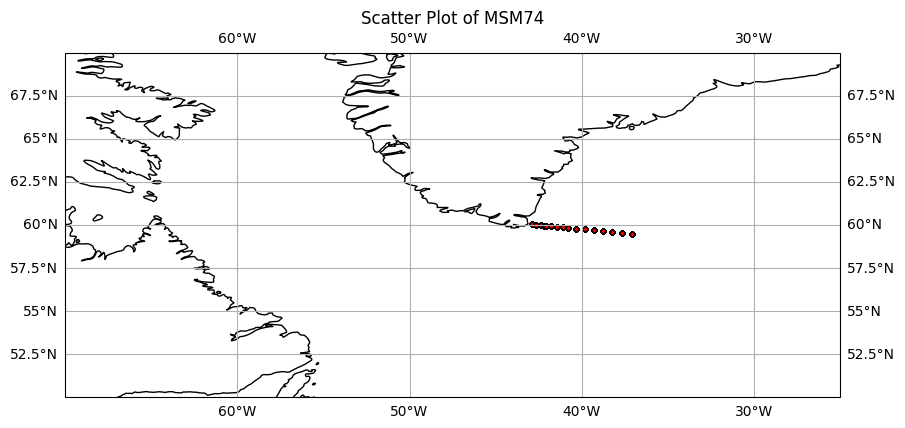

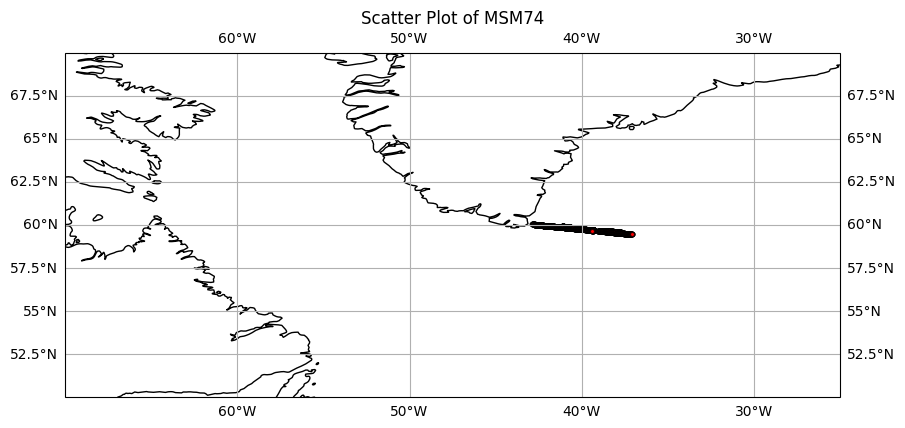

In [21]:
plot_coords(lon, lat)
plot_coords(lon_adcp_section, lat_adcp_section)

In [22]:
distance = determine_distance(lon, lat, inv_x, section_num)
distance_adcp = determine_distance(lon_adcp_section, lat_adcp_section, inv_x, section_num)

v_ortho = calc_ortho_vel(section_num, cruise, lon_adcp_section, lat_adcp_section, u_adcp, v_adcp)
# v_ortho1 = compute_orthogonal_velocity(lon_adcp_section, lat_adcp_section, u_adcp, v_adcp)

distance, depth, v_ortho, lon_adcp_section, lat_adcp_section, distance_adcp, times, press, depth, T, S, lon, lat = snip_data(distance, depth, section_num, v_ortho, lon_adcp_section, lat_adcp_section, distance_adcp, times, press, depth, T, S, lon, lat)

if section_num == 1:
    distance_adcp = np.linspace(np.min(distance), np.max(distance), len(distance_adcp))

# Convert practical salinity to absolute salinity
SA = gsw.SA_from_SP(S, press, lon, lat)  # Longitude and Latitude needed

# Convert in situ temperature to conservative temperature
CT = gsw.CT_from_t(SA, T, press)

# Calculate in situ density (kg/m³)
rho = gsw.rho(SA, CT, press)

# Calculate potential density anomaly referenced to 0 dbar
sigma0 = gsw.sigma0(SA, CT)  # Potential density anomaly (kg/m³ - 1000)

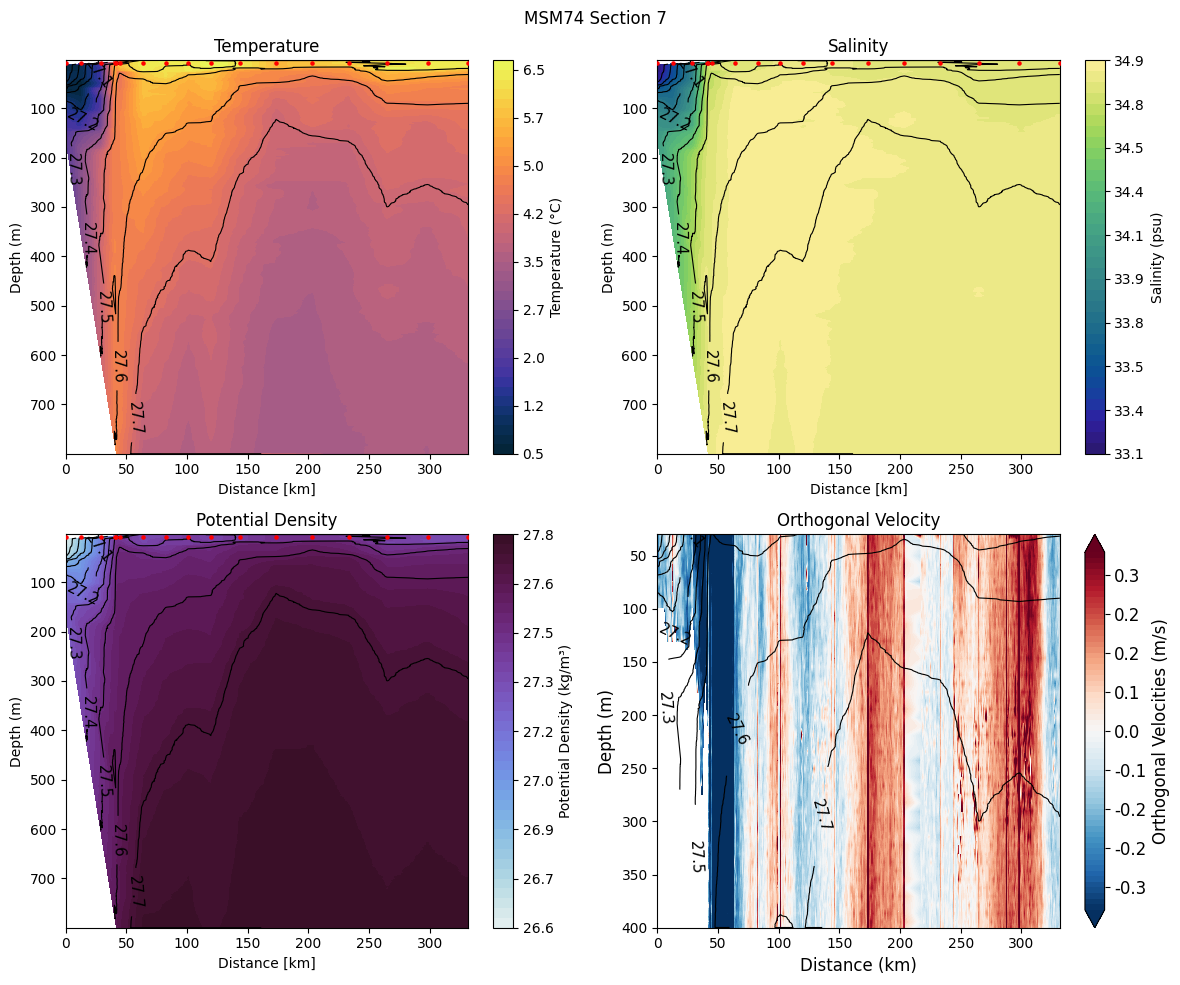

In [23]:
plot_section_data(distance, depth, distance_adcp, depth_adcp, T, S, sigma0, v_ortho, section_num, inv_x=inv_x, depth_max_adcp=400)

NameError: name 'V_plot' is not defined

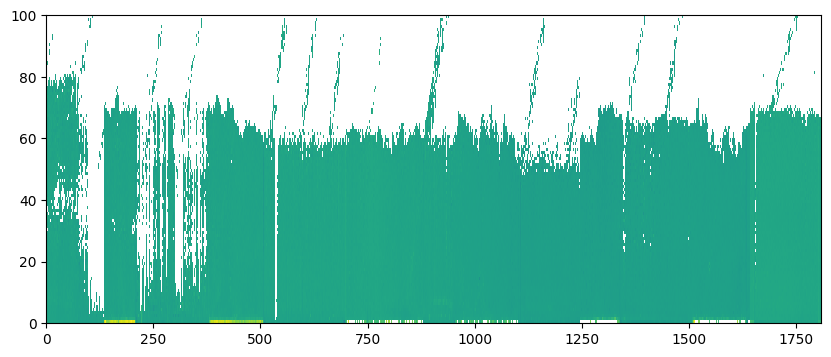

In [15]:
plt.figure(figsize=(10,4))
depth_max_adcp = 300
depth_min_adcp=25
# Reshape the 1D arrays into a 2D grid
distance_grid, depth_grid = np.meshgrid(distance_adcp, depth_adcp)

# Plot Velocity
levels_velocity=np.linspace(-0.4, 0.5, 200)
plt.pcolormesh(v_adcp)
# V_plot = plt.pcolormesh(distance_grid, depth_grid, v_adcp, levels=levels_velocity, vmin=-0.4, vmax=0.4, cmap='coolwarm',extend='both')
cbar=plt.colorbar(V_plot)
cbar.set_label('Orthogonal velocities (m/s)',fontsize=15)
cbar.ax.tick_params(labelsize=15)

contour_levels = np.arange(23, 28, 0.1)
clines = plt.tricontour(distance, depth, sigma0,
                                levels=contour_levels, colors='k', linewidths=0.8)
clines.clabel(inline=True, fmt='%1.1f', fontsize=11)

# contour_lines = plt.contour(distance, depth, sigma0, levels=contour_levels, colors='k', linewidths=0.3)
# plt.clabel(contour_lines, inline=True, fmt='%1.1f', fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=15)
plt.clim(-0.4, 0.4)
plt.ylim(depth_min_adcp, depth_max_adcp)
plt.xlabel('Distance (km)',fontsize=15)
plt.ylabel('Depth (m)',fontsize=15)
plt.gca().invert_yaxis() 
if inv_x:
    plt.gca().invert_xaxis()
plt.title(f"Orthogonal Velocities Méthode Yan MSM74 Section {section_num}")
plt.tight_layout()


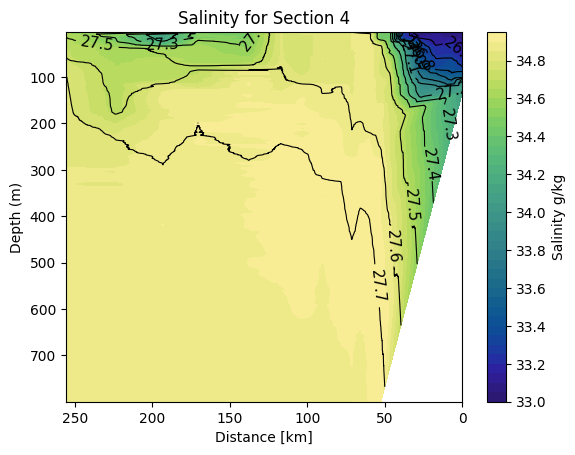

In [14]:
mask = (S > 30) 
S_filtered = S[mask]
distance_f = distance[mask]
depths_filtered = depth[mask]
sigma0_ = sigma0[mask]
contour_var(distance_f, depths_filtered, S_filtered, sigma0_, f"Salinity for Section {section_num}", "Salinity g/kg", colormap='cmo.haline', x_invt = inv_x)

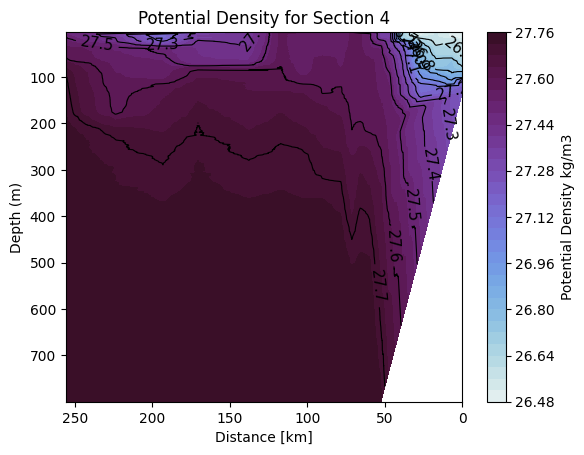

In [15]:
contour_var(distance, depth, sigma0, sigma0, f"Potential Density for Section {section_num}", "Potential Density kg/m3", colormap='cmo.dense', x_invt=inv_x)